In [99]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 28 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.68 MiB | 28.23 MiB/s, done.
Resolving deltas: 100% (11719/11719), done.
/content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5


In [100]:
import torch
import os
import shutil
import utils
display = utils.notebook_init()

YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.9/112.6 GB disk)


In [101]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [102]:
import json
import os
import shutil
from tqdm import tqdm

# Define paths
datafolder = "/content/drive/MyDrive/val2017"  # Folder containing image files
json_path = "/content/drive/MyDrive/instances_val2017/instances_val2017.json"  # Path to COCO JSON file
output_dir = "datayolo"  # YOLO dataset output directory

# Create YOLO directory structure
os.makedirs(f"{output_dir}/train/images", exist_ok=True)
os.makedirs(f"{output_dir}/train/labels", exist_ok=True)
os.makedirs(f"{output_dir}/val/images", exist_ok=True)
os.makedirs(f"{output_dir}/val/labels", exist_ok=True)
os.makedirs(f"{output_dir}/test/images", exist_ok=True)
os.makedirs(f"{output_dir}/test/labels", exist_ok=True)

# Supported YOLO classes (COCO's first 80 classes)
yolo_coco_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog",
    "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag",
    "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]
category_mapping = {cat['id']: idx for idx, cat in enumerate(json.load(open(json_path))["categories"]) if cat['name'] in yolo_coco_classes}

# Load COCO JSON data
with open(json_path, "r") as f:
    coco_data = json.load(f)

# Map images to their metadata
image_data = {
    img["id"]: {"file_name": img["file_name"], "width": img["width"], "height": img["height"], "bboxes": []}
    for img in coco_data["images"]
}

# Filter and add annotations
for ann in coco_data["annotations"]:
    if ann["category_id"] in category_mapping:  # Only include YOLO-supported classes
        class_id = category_mapping[ann["category_id"]]
        bbox = ann["bbox"]  # x, y, width, height
        image_data[ann["image_id"]]["bboxes"].append((class_id, bbox))

# Prepare the YOLO dataset
for i, (image_id, data) in tqdm(enumerate(image_data.items()), desc="Preparing YOLO dataset"):
    width, height = data["width"], data["height"]
    name = os.path.splitext(data["file_name"])[0]
    src = os.path.join(datafolder, data["file_name"])

    if i < 100:  # Train set
        dst_img = f"{output_dir}/train/images/{name}.jpg"
        dst_label = f"{output_dir}/train/labels/{name}.txt"
    elif i < 150:  # Validation set
        dst_img = f"{output_dir}/val/images/{name}.jpg"
        dst_label = f"{output_dir}/val/labels/{name}.txt"
    elif i < 200:  # Test set
        dst_img = f"{output_dir}/test/images/{name}.jpg"
        dst_label = f"{output_dir}/test/labels/{name}.txt"
    else:
        continue

    if not os.path.exists(src):
        print(f"Image not found: {src}. Skipping...")
        continue

    shutil.copyfile(src, dst_img)

    with open(dst_label, "w") as f:
        for class_id, box in data["bboxes"]:
            x, y, w, h = box
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            norm_width = w / width
            norm_height = h / height
            f.write(f"{class_id} {x_center} {y_center} {norm_width} {norm_height}\n")

# Generate data.yaml
data_yaml = f"""train: ../datayolo/train/images
val: ../datayolo/val/images

nc: 80
names: {yolo_coco_classes}
"""
with open(f"{output_dir}/data.yaml", "w") as f:
    f.write(data_yaml)

print("Dataset preparation completed successfully!")


Preparing YOLO dataset: 166it [00:00, 226.99it/s]

Image not found: /content/drive/MyDrive/val2017/000000494869.jpg. Skipping...
Image not found: /content/drive/MyDrive/val2017/000000329219.jpg. Skipping...
Image not found: /content/drive/MyDrive/val2017/000000127182.jpg. Skipping...


Preparing YOLO dataset: 5000it [00:00, 5219.41it/s]

Dataset preparation completed successfully!


In [103]:
# Train YOLOv5 on the prepared dataset
!python train.py --img 640 --batch 16 --epochs 10 --data ../datayolo/data.yaml --weights yolov5s.pt --name yolov5_custom


2024-12-02 09:26:20.976318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 09:26:21.023618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 09:26:21.034598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=../datayolo/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=

In [104]:
# Run inference on test images
!python detect.py --weights runs/train/yolov5_custom/weights/best.pt --img 640 --conf 0.25 --source ../datayolo/test/images


detect: weights=['runs/train/yolov5_custom/weights/best.pt'], source=../datayolo/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/50 /content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/datayolo/test/images/000000008021.jpg: 480x640 4 persons, 1 tie, 31.6ms
image 2/50 /content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/datayolo/test/images/000000030675.

In [105]:
!python detect.py --weights runs/train/yolov5_custom/weights/best.pt --source /content/drive/MyDrive/val2017/000000000139.jpg


detect: weights=['runs/train/yolov5_custom/weights/best.pt'], source=/content/drive/MyDrive/val2017/000000000139.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/val2017/000000000139.jpg: 448x640 1 person, 1 bottle, 3 chairs, 3 potted plants, 3 dining tables, 2 tvs, 3 refrigerators, 1 clock, 3 vases, 30.2ms
Speed: 0.5ms pre-process, 30.2ms inference, 594.7ms NM

detect: weights=['runs/train/yolov5_custom/weights/best.pt'], source=/content/drive/MyDrive/val2017/000000000139.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5_detect, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/val2017/000000000139.jpg: 448x640 1 person, 1 bottle, 3 chairs, 3 potted plants, 3 dining tables, 2 tvs, 3 refrigerators, 1 clock, 3 vases, 30.2ms
Speed: 0.5ms pre-process, 30.2ms inference, 56

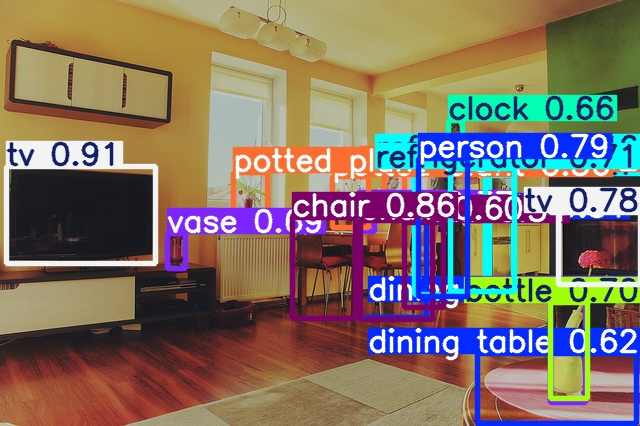

In [106]:
from IPython.display import display
from PIL import Image as PILImage
import cv2
import matplotlib.pyplot as plt

# Path to the weights and the source image
weights_path = "runs/train/yolov5_custom/weights/best.pt"
source_image = "/content/drive/MyDrive/val2017/000000000139.jpg"
output_dir = "runs/detect/yolov5_detect"

# Run YOLOv5 detection
!python detect.py --weights {weights_path} --source {source_image} --name yolov5_detect --save-txt --save-conf

# Path to the detected image
detected_image_path = f"{output_dir}/000000000139.jpg"

# Open the image using PIL and display it
image = PILImage.open(detected_image_path)

# Display image using IPython's display function
display(image)
